In [65]:
#!pip install numpy
#!pip install sklearn

In [66]:
# Import useful libraries
import numpy as np
import sklearn as skl
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd 

In [67]:
# Import useful functions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn import svm
from scipy.signal import argrelmin
from sklearn.preprocessing import StandardScaler

In [68]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")

## TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

<b>MARENGO Matteo & ROBERT Hugo </b>

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br> 
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)

- la largeur ou durée de l'impulsion (en ms)

- la puissance de l'impulsion (en dB / référence) 

- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)

- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 

- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 

- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

</div>    

# 1) Visualisation des données

Tout d'abord, on cherche à visualiser les données par caractéristique selon la nature du signal (menace ou non menace) :

In [69]:
# on récupère les indices des signaux menace et non menace
with open('./radars/train_labels.json') as f: 
    test_labels = json.load(f)
menace_index, non_menace_index = [], []
i=0
while(i<len(test_labels)):
    if (test_labels[f'pdw-{i}'] == 'menace'):
        menace_index.append(i)
    if (test_labels[f'pdw-{i}'] == 'nonmenace'):
        non_menace_index.append(i)
    i+=1

print(f"Les indices des signaux menace sont: {menace_index}")
print(f"Les indices des signaux non menace sont: {non_menace_index}\n")
# On vérifie que le dataset soit équilibré
print(f"Nombre de signaux menace: {len(menace_index)}")
print(f"Nombre de signaux non menace: {len(non_menace_index)}")

Les indices des signaux menace sont: [2, 5, 6, 7, 8, 10, 11, 12, 14, 17, 19, 23, 24, 25, 30, 33, 34, 35, 37, 38, 39, 40, 43, 45, 46, 47, 52, 54, 55, 56, 57, 63, 64, 65, 66, 68, 69, 70, 72, 73, 75, 76, 77, 81, 82, 84, 85, 86, 87, 88, 89, 93, 96, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 110, 111, 114, 116, 117, 120, 121, 122, 124, 128, 130, 132, 142, 144, 145, 149, 151, 158, 159, 160, 161, 162, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181, 183, 185, 186, 188, 190, 191, 195, 199, 200, 202, 203, 204, 206, 207, 209, 211, 213, 215, 217, 219, 221, 222, 223, 225, 227, 228, 229, 233, 235, 236, 238, 240, 241, 243, 244, 246, 247, 248, 250, 253, 254, 255, 257, 258, 259, 261, 262, 266, 267, 268, 270, 273, 274, 276, 278, 281, 284, 285, 286, 290, 291, 292, 293, 294, 296, 297, 299, 301, 304, 311, 313, 316, 318, 320, 324, 326, 327, 332, 333, 334, 338, 339, 342, 344, 345, 346, 347, 352, 353, 354, 355, 357, 368, 369, 370, 371, 375, 376, 377, 378, 380, 381, 382, 384, 385, 386, 387, 390

In [70]:
def create_df(size_s = 1):
    """return a dataframe with all data with size_s samples of menace and size_s samples of non menace signals

    Args:
        size_s (int, optional): number of menace and non menace samples to take. Defaults to 1.

    Returns:
        df: dataframe with all data of samples
    """
    df=pd.DataFrame()
    for index in menace_index[:size_s]:
        pdw = np.load(f'./radars/train/pdw-{index}.npz')
        dates = pdw['date']
        largeurs = pdw['largeur']
        frequences=pdw['frequence']
        puissances = pdw['puissance']
        theta = pdw['theta']
        phi = pdw['phi']
        df_pdw = pd.DataFrame({'date':dates, 'largeur':largeurs, 'frequence':frequences, 'puissance':puissances, 'theta':theta, 'phi':phi})
        df_pdw['menace'] = 1
        df_pdw['index'] = index
        df = pd.concat([df, df_pdw])
    for index in non_menace_index[:size_s]:
        pdw = np.load(f'./radars/train/pdw-{index}.npz')
        dates = pdw['date']
        largeurs = pdw['largeur']
        frequences=pdw['frequence']
        puissances = pdw['puissance']
        theta = pdw['theta']
        phi = pdw['phi']
        df_pdw = pd.DataFrame({'date':dates, 'largeur':largeurs, 'frequence':frequences, 'puissance':puissances, 'theta':theta, 'phi':phi})
        df_pdw['menace'] = 0
        df_pdw['index'] = index
        df = pd.concat([df, df_pdw])
    return df

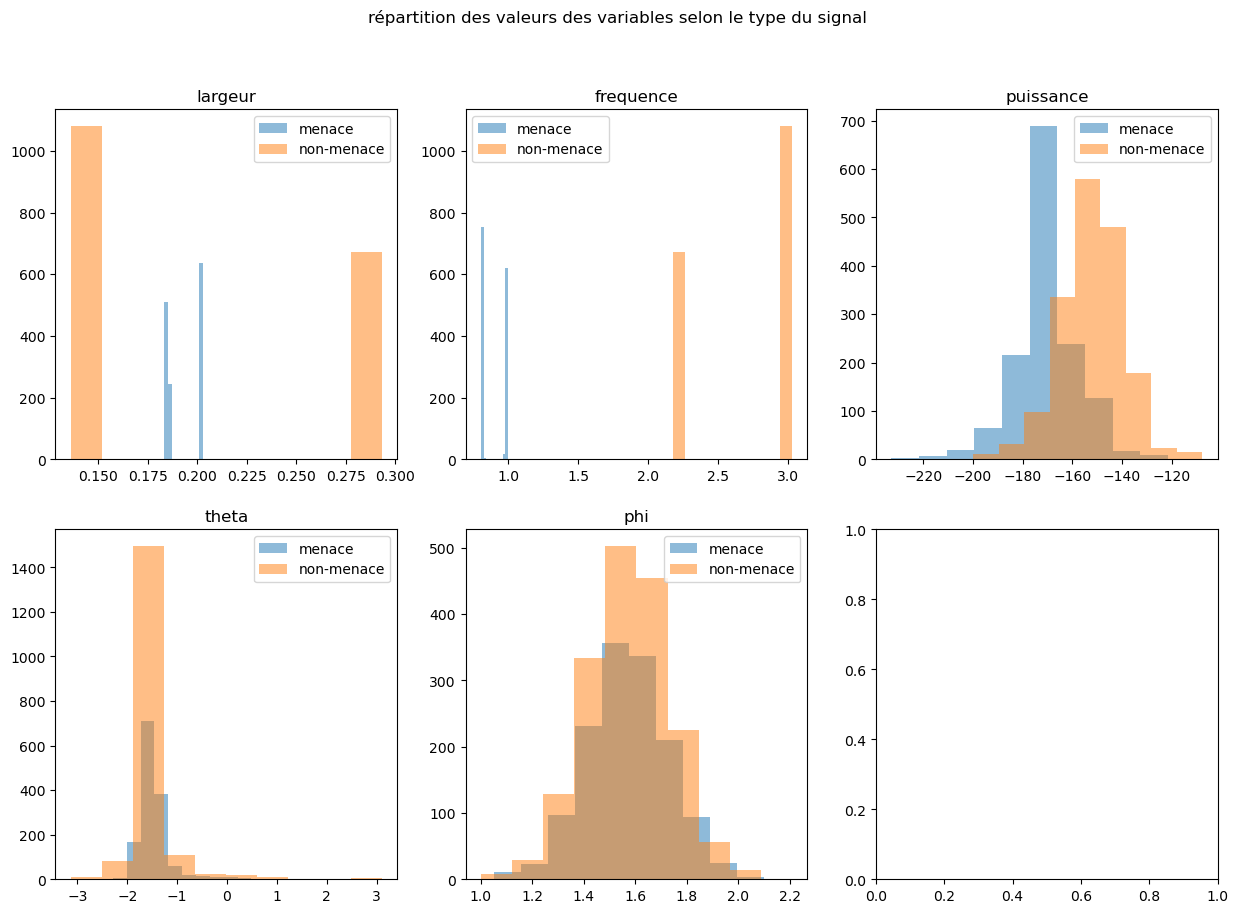

In [71]:
# observons la distribution de chaque variables selon le type de signal (menace ou non menace) pour seulement 2 signaux menaces et 2 signaux non menaces
df_size2 = create_df(2)
fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('répartition des valeurs des variables selon le type du signal')
i=0
for col in ['largeur', 'frequence', 'puissance', 'theta', 'phi']:
    # plot in the right subplot
    axs[i//3, i%3].hist(df_size2[df_size2["menace"]==1][col], label="menace", alpha=0.5)
    axs[i//3, i%3].hist(df_size2[df_size2["menace"]==0][col], label="non-menace", alpha=0.5)
    axs[i//3, i%3].legend()
    axs[i//3, i%3].set_title(col)
    i+=1
plt.show()
        

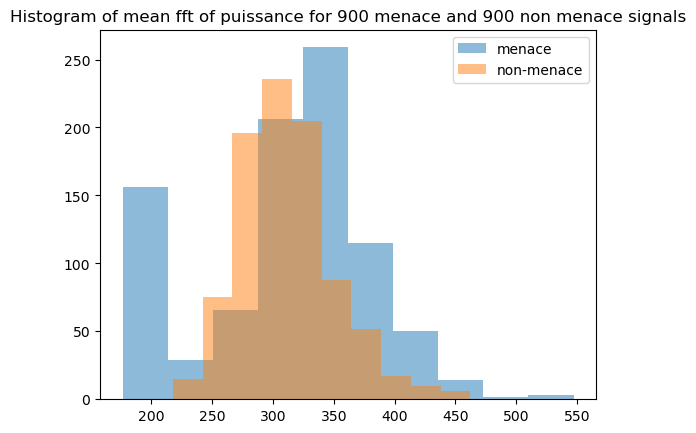

In [72]:
# On peut étudier une autre variable intéressante qui est le max de la transformée de Fourier de la puissance

# load the labels
with open('./radars/train_labels.json') as f: 
    train_labels = json.load(f)

# get the indices of the menace and non-menace signals
menace_index, non_menace_index = [], []
i=0
while(i<len(train_labels)):
    if (train_labels[f'pdw-{i}'] == 'menace'):
        menace_index.append(i)
    if (train_labels[f'pdw-{i}'] == 'nonmenace'):
        non_menace_index.append(i)
    i+=1

# get the max fft of puissance for 10 menace and 10 non menace signals
max_fft_puissance_menace = []
max_fft_puissance_non_menace = []
for index in menace_index[:900]:
    pdw = np.load(f'./radars/train/pdw-{index}.npz')
    puissance = pdw['puissance']
    fft_puissance = np.abs(np.fft.fft(puissance))
    max_fft_puissance_menace.append(np.mean(fft_puissance))
for index in non_menace_index[:900]:
    pdw = np.load(f'./radars/train/pdw-{index}.npz')
    puissance = pdw['puissance']
    fft_puissance = np.abs(np.fft.fft(puissance))
    max_fft_puissance_non_menace.append(np.mean(fft_puissance))

# plot the histograms on the same figure
plt.hist(max_fft_puissance_menace, alpha=0.5, label='menace')
plt.hist(max_fft_puissance_non_menace, alpha=0.5, label='non-menace')
plt.legend()
plt.title('Histogram of mean fft of puissance for 900 menace and 900 non menace signals')
plt.show()




### Observations: 
<br/>Après une première observation rapide, la fréquence semble être le facteur le plus discriminant, nous allons tester un modèle naïf qui discrimine les signaux selon la fréquence. <br/>On note par ailleurs que la largeur et que la moyenne de la fft de la puissance sont aussi discrimantes, et pourront être utilisées pour un modèle plus avancé.

Pour chaque signal on calcul la moyenne et l'écart type de sa fréquence, puis on affiche la répartition de ces 2 valeurs pour les signaux menaces puis pour les signaux non-menaces sur un échantillon de taille 100:

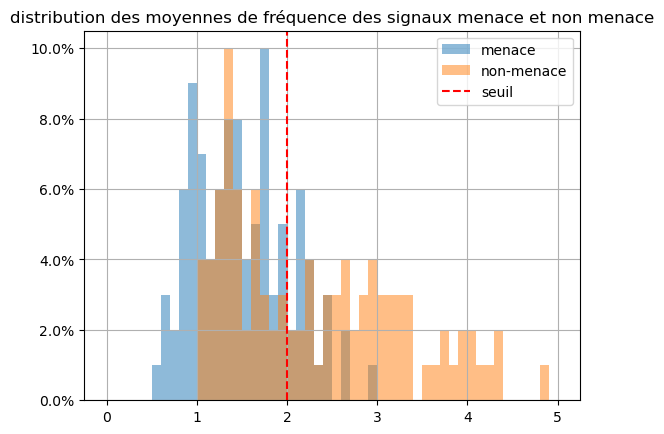

In [73]:
df_size100 = create_df(100)
mean_frequence_menace = df_size100.where(df_size100['menace']==1).groupby('index').mean()['frequence']
mean_frequence_non_menace = df_size100.where(df_size100['menace']==0).groupby('index').mean()['frequence']
mean_frequence_menace.hist(alpha=0.5, label="menace", range=(0, 5), bins=50, weights=np.ones(len(mean_frequence_menace)) / len(mean_frequence_menace))
mean_frequence_non_menace.hist(alpha=0.5, label="non-menace", range=(0, 5), bins=50, weights=np.ones(len(mean_frequence_non_menace)) / len(mean_frequence_non_menace))
# la valeur seuil a été définit suite à la lecture de la distribution, elle est détaillé ci-dessous
plt.axvline(x=2, color='r', linestyle='--', label="seuil")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('distribution des moyennes de fréquence des signaux menace et non menace')
plt.show()


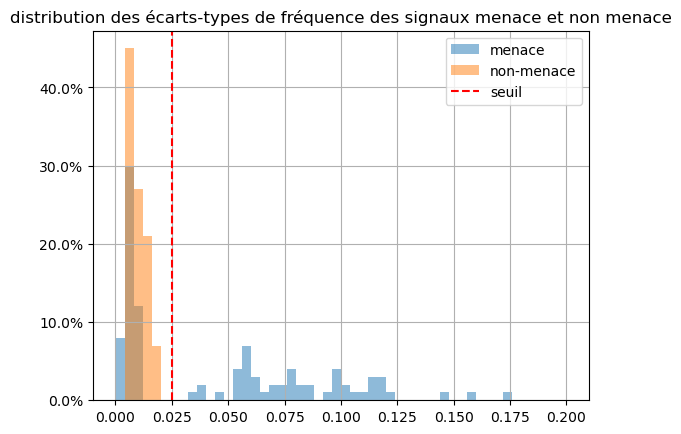

In [74]:
std_f_menace = df_size100.where(df_size100['menace']==1).groupby('index').std()['frequence']
std_f_menace.hist(alpha=0.5, label="menace", range=(0, 0.2), bins=50, weights=np.ones(len(std_f_menace)) / len(std_f_menace))
std_f_non_menace = df_size100.where(df_size100['menace']==0).groupby('index').std()['frequence']
std_f_non_menace.hist(alpha=0.5, label="non-menace", range=(0, 0.2), bins=50, weights=np.ones(len(std_f_non_menace)) / len(std_f_non_menace))
# la valeur seuil a été définit suite à la lecture de la distribution, elle est détaillé ci-dessous
plt.axvline(x=0.025, color='r', linestyle='--', label="seuil")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('distribution des écarts-types de fréquence des signaux menace et non menace')
plt.show()

On observe que généralement, si l'écart type est inférieur à 0.025 ET que la moyenne de fréquence est supérieur à 2, alors ce n'est pas une menace, sinon c'est une menace. Nous pouvons donc réaliser un premier modèle de prédiction naïf à partir de ces observations.

On peut également observer ces caractéristiques (std et mean de la fréquence sont les plus clivants) avec plus de signaux

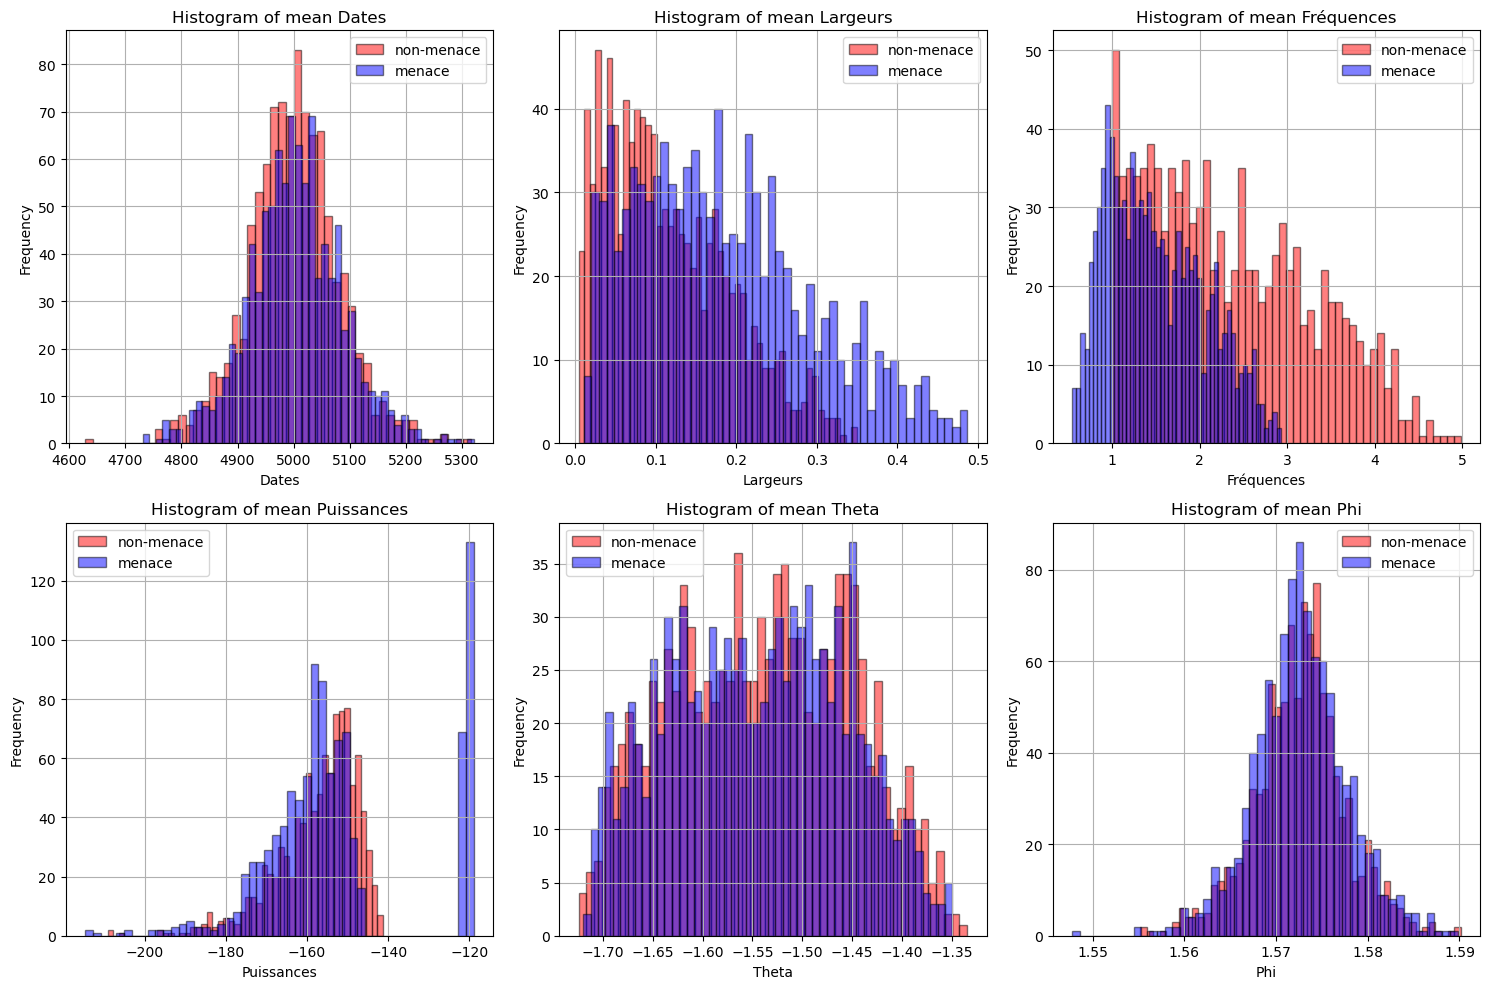

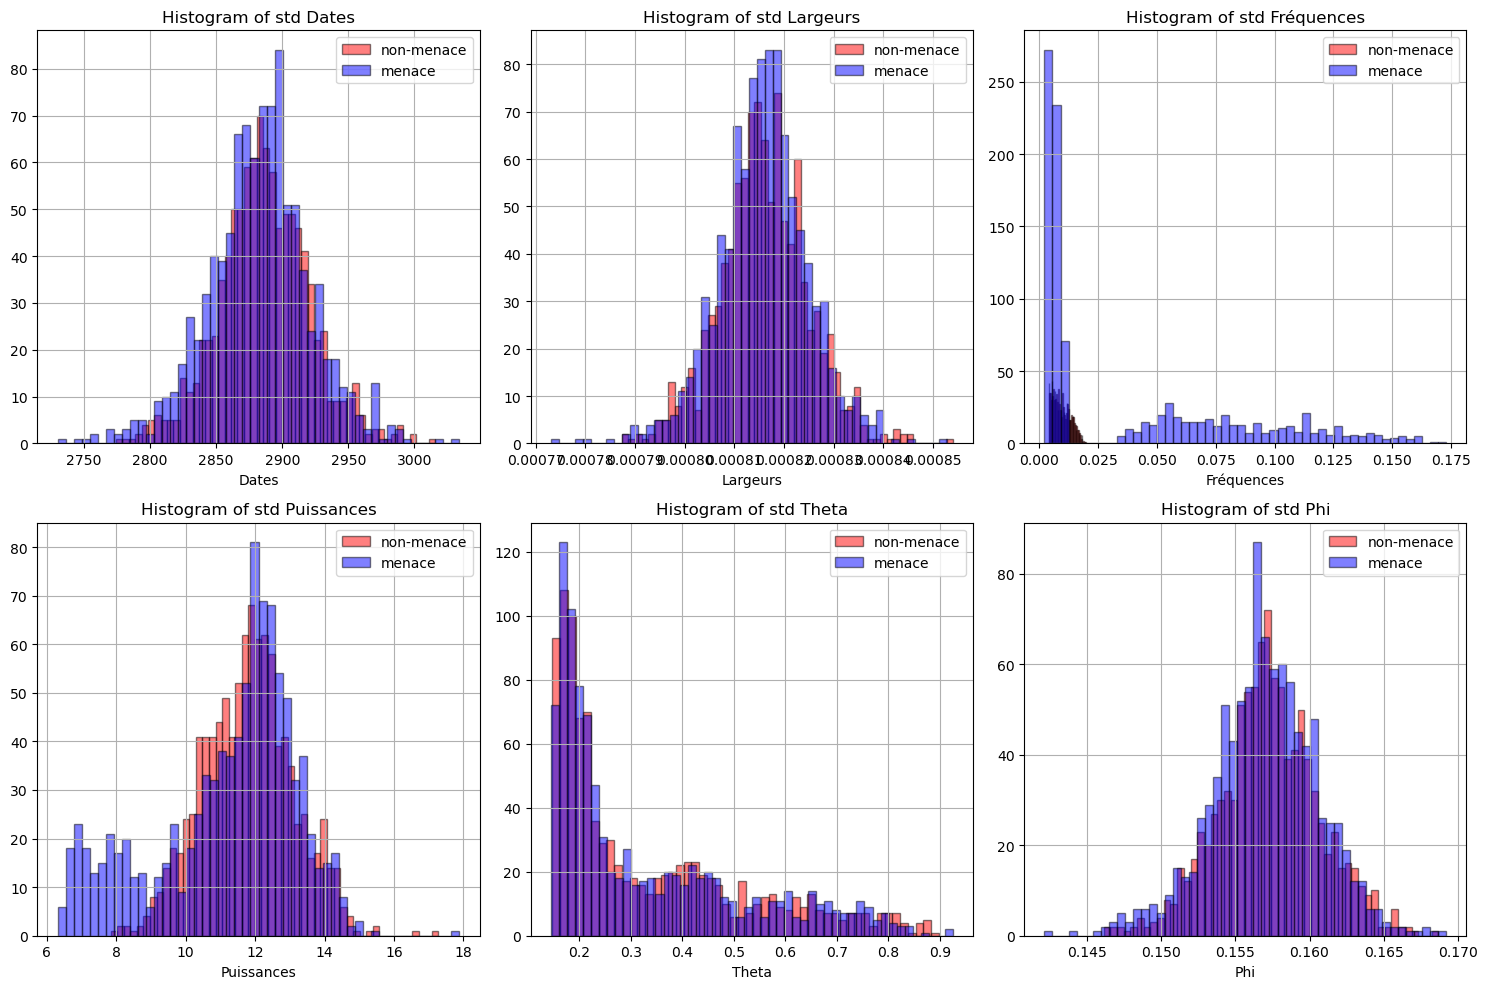

In [75]:
# extract the label from train_labels.json
with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

menace_index = []
nonmenace_index = []
for i in range(2000):
    if dict_labels[f'pdw-{i}'] == 'menace':
        menace_index.append(i)
    else:
        nonmenace_index.append(i)

# Load the data
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # create subplots for each variable
axs = axs.flatten()  # flatten the 2D array of axes to 1D for easy indexing
labels = ['Dates', 'Largeurs', 'Fréquences', 'Puissances', 'Theta', 'Phi']
lablab = ['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']

for i in range(6):
    nonmenace_data = []
    for index in nonmenace_index:
        pdws = np.load(f'./radars/train/pdw-{index}.npz')
        data = np.mean(pdws[lablab[i]])
        nonmenace_data.append(data)
    
    menace_data = []
    for index in menace_index:
        pdws = np.load(f'./radars/train/pdw-{index}.npz')
        data = np.mean(pdws[lablab[i]])
        menace_data.append(data)
    
    axs[i].hist(nonmenace_data, bins=50, edgecolor='black', color='red', alpha=0.5, label='non-menace')
    axs[i].hist(menace_data, bins=50, edgecolor='black', color='blue', alpha=0.5, label='menace')
    
    axs[i].set_title(f'Histogram of mean {labels[i]}')
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()  # adjust the spacing between subplots
plt.show()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # create subplots for each variable
axs = axs.flatten()  # flatten the 2D array of axes to 1D for easy indexing
labels = ['Dates', 'Largeurs', 'Fréquences', 'Puissances', 'Theta', 'Phi']
lablab = ['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']

for i in range(6):
    nonmenace_data = []
    for index in nonmenace_index:
        pdws = np.load(f'./radars/train/pdw-{index}.npz')
        data = np.std(pdws[lablab[i]])
        nonmenace_data.append(data)
    
    menace_data = []
    for index in menace_index:
        pdws = np.load(f'./radars/train/pdw-{index}.npz')
        data = np.std(pdws[lablab[i]])
        menace_data.append(data)
    
    axs[i].hist(nonmenace_data, bins=50, edgecolor='black', color='red', alpha=0.5, label='non-menace')
    axs[i].hist(menace_data, bins=50, edgecolor='black', color='blue', alpha=0.5, label='menace')
    
    axs[i].set_title(f'Histogram of std {labels[i]}')
    axs[i].set_xlabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()  # adjust the spacing between subplots
plt.show()


# 2) Modèle naïf

Suite aux observations réalisées précédement, nous décidons d'implémenter un modèle naïf qui servira de référentiel pour la suite. 
Le modèle fonctionne de la manière suiante : si l'écart type est inférieur à 0.025 ET que la moyenne de fréquence est supérieur à 2, alors ce n'est pas une menace, sinon c'est une menace. Nous pouvons donc réaliser un premier modèle de prédiction naïf à partir de ces observations.

In [76]:
def naive_pred(i):
    """for a sample i, return 1 if the model predicts menace, 0 otherwise

    Args:
        i (int): _description_

    Returns:
        _type_: _description_
    """
    pdws = np.load('./radars/test/pdw-'+str(i)+'.npz')
    frequences=pdws['frequence']
    if np.std(frequences)>0.025:
        return 1
    else:
        if np.mean(frequences)<2:
            return 1
    return 0

accuracy: 0.73875
precision: 0.6746031746031746
recall: 0.8831168831168831
f1-score: 0.7649043869516311


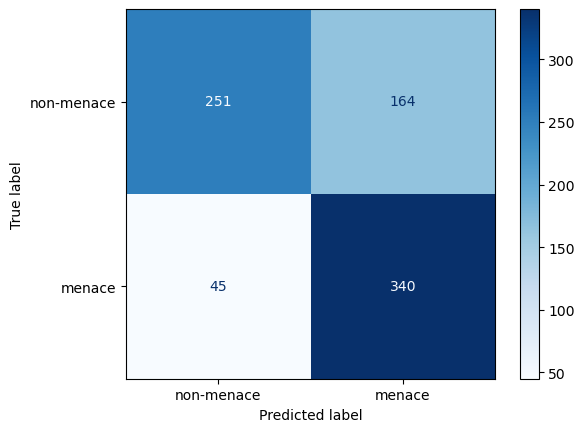

In [77]:
#test du modèle
with open('./radars/test_labels.json') as f: 
    test_labels = json.load(f)
    test_labels = [test_labels[f'pdw-{i}']=='menace' for i in range(len(test_labels))]

total = len(test_labels)
score=0
preds=[]
for i in range(total):
    preds.append(naive_pred(i))
# plot results
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, preds), display_labels=['non-menace', 'menace'])
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(f"precision: {precision_score(test_labels, preds)}")
print(f"recall: {recall_score(test_labels, preds)}")
print(f"f1-score: {f1_score(test_labels, preds)}")


La valeur 0.74 pour l'accuracy va donc nous servir de référence pour mesurer l'efficacité d'un modèle plus avancé. <br/>
On remarque par ailleurs que le nombre de faux negatifs (45) et environ 3 fois plus faible que le nombre de faux positifs (164), c'est un point qui sera abordé en fin de rapport.

# 3) Modèle avancé

## Trouver les features pertinentes

Afin de créer un modèle le plus efficace possible, il est important de déterminer quelles sont les features intéressantes à tirer du dataset. Nous avons donc décelé un ensemble de features dont le sens physique va permettre de discriminer le fait que la source est une menace ou non:
- <b>fréquence:</b> comme vu dans le domaine naïf, la moyenne est l'éacrt type de la fréquence semblent apporter de l'information sur la nature d'une potentielle menace. Il est donc naturel de d'ajouter les caractéristiques de fréquence du signal dans les features du modèle (std, mean).

- <b>temps T entre l'envoie des impulsions:</b> le temps d'envoie entre plusieurs impulsions peut permettre de déterminer la nature du radar "ennemi" pour savoir par exemple si c'est un radar pouvant représenter une menace (ex: radar militaire) ou non (ex: radar météo). Il est déterminé par la fonction compute_T à partir de la caractéristique "time".

- <b>puissance:</b> la puissance du signal obtenu définit la nature même du signal recu, il est donc pertinent d'essayer d'en extraire un maximum d'informations, comme par exemple le nombre de lob (ou par équivalence son nombre de minima locaux), et la largeur/hauteur du lob le plus large. C'est donnée sont extraites grâce à la fonction compute_large_lob.

- <b>largeur:</b> comme vu dans la visualisation des données, la largeur d'impulsion semblent être également une propriété discriminante selon le ttype de signaux.

In [78]:
def compute_T(time):
    """_summary_

    Args:
        time (_type_): _description_

    Returns:
        _type_: _description_
    """
    delta_t = np.diff(time)
    # afin d'obtenir d'estimer une valeur de T le plus précisemment et rapidement
    # on mesure la moyenne des 20 éléments les plus petits de delta_t qui donnent chacun une estimation de T
    delta_t.sort()
    return np.mean(delta_t[:20])

In [79]:
def compute_large_lob(puissance):
    """compute caracteristics of puissance curve

    Args:
        puissance (Any)

    Returns:
        nb_local_minimum (int): number of local minimum in puissance
        weight_large_lob (int): weight of the largest lob
        height_large_lob (int): height of the largest lob
    """
    local_min_indexes = argrelmin(puissance, order=2)[0] #  computation of local minimum indexes
    # caracteristics of largest lob
    index_begin_large_lob = local_min_indexes[np.argmax(np.diff(local_min_indexes))]
    index_end_large_lob = local_min_indexes[1+np.argmax(np.diff(local_min_indexes))]
    height_large_lob = np.max(puissance[index_begin_large_lob:index_end_large_lob])-puissance[index_end_large_lob]
    weight_large_lob = np.max(np.diff(local_min_indexes)) * 10/len(puissance)
    return len(local_min_indexes), weight_large_lob, height_large_lob

In [80]:
from scipy.stats import skew, kurtosis

def statistical_metrics(data):
    """return statistical metrics of data

    Args:
        data 

    Returns:
        mean, std, max, min, skew, kurtosis
    """
    return np.mean(data), np.std(data), np.max(data), np.min(data), skew(data), kurtosis(data)

## Création des données Test & Train

In [81]:
with open('./radars/train_labels.json') as f: 
    dict_labels_train = json.load(f)
    print('Number of training examples: ',len(dict_labels_train)) # number of training examples

with open('./radars/test_labels.json') as f: 
    dict_labels_test = json.load(f)
    print('Number of test examples: ',len(dict_labels_test)) # number of test examples

# Load the train data in a dataset to perform binary classification

X_train = np.zeros((len(dict_labels_train),16))
y_train = np.zeros((len(dict_labels_train),1))
X_test = np.zeros((len(dict_labels_test),16))
y_test = np.zeros((len(dict_labels_test),1))
print ('Création de X_train, y_train, X_test et y_test\n')
print('Format des données:')
print('\tFormat de X_train: ',X_train.shape)
print('\tFormat de y_train: ',y_train.shape)
print('\tFormat de X_test: ',X_test.shape)
print('\tFormat de y_test: ',y_test.shape)

for i in range(len(dict_labels_train)):
    pdws = np.load('./radars/train/pdw-'+str(i)+'.npz')
    frequences=pdws['frequence']
    largeurs = pdws['largeur']
    puissances = pdws['puissance']
    fft_puissance = abs(np.fft.fft(puissances))
    fft_frequence = abs(np.fft.fft(frequences))
    phi = pdws['phi']
    theta = pdws['theta']
    
    if dict_labels_train[f'pdw-{i}'] == 'menace':
        y_train[i] = 1
    else:
        y_train[i] = 0
    X_train[i,0]=np.std(frequences)
    X_train[i,1]=np.mean(frequences)
    X_train[i,2]=np.mean(largeurs)
    X_train[i,3]=np.mean(puissances)
    X_train[i,4]=compute_T(pdws['date'])
    X_train[i,5]=np.max(fft_puissance)
    X_train[i,6]=np.min(fft_puissance)
    X_train[i,7]=np.mean(fft_puissance)
    X_train[i,8]=np.std(fft_puissance)
    X_train[i,9], X_train[i,10], X_train[i,11] = compute_large_lob(puissances)
    X_train[i,12]=np.max(fft_frequence)
    X_train[i,13]=np.min(fft_frequence)
    X_train[i,14]=np.mean(fft_frequence)
    X_train[i,15]=np.std(fft_frequence)

for i in range(len(dict_labels_test)):
    pdws = np.load('./radars/test/pdw-'+str(i)+'.npz')
    frequences=pdws['frequence']
    largeurs = pdws['largeur']
    puissances = pdws['puissance']
    fft_puissance = abs(np.fft.fft(puissances))
    fft_frequence = abs(np.fft.fft(frequences))
    phi = pdws['phi']
    theta = pdws['theta']

    if dict_labels_test[f'pdw-{i}'] == 'menace':
        y_test[i] = 1
    else:
        y_test[i] = 0
    X_test[i,0]=np.std(frequences)
    X_test[i,1]=np.mean(frequences)
    X_test[i,2]=np.mean(largeurs)
    X_test[i,3]=np.mean(puissances)
    X_test[i,4]=compute_T(pdws['date'])
    X_test[i,5]=np.max(fft_puissance)
    X_test[i,6]=np.min(fft_puissance)
    X_test[i,7]=np.mean(fft_puissance)
    X_test[i,8]=np.std(fft_puissance)
    X_test[i,9], X_test[i,10], X_test[i,11] = compute_large_lob(puissances)
    X_test[i,12]=np.max(fft_frequence)
    X_test[i,13]=np.min(fft_frequence)
    X_test[i,14]=np.mean(fft_frequence)
    X_test[i,15]=np.std(fft_frequence)

y_train = y_train.ravel()
y_test = y_test.ravel()

# Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print ('Data are normalized !\n')



Number of training examples:  2000
Number of test examples:  800
Création de X_train, y_train, X_test et y_test

Format des données:
	Format de X_train:  (2000, 16)
	Format de y_train:  (2000, 1)
	Format de X_test:  (800, 16)
	Format de y_test:  (800, 1)
Data are normalized !



## Méthodes de classification binaires

Afin de pouvoir déterminer empiriquement quel modèle est le plus adapté, nous essayons plusieurs méthodes de classification sans paramètres avancés afin d'utiliser par la suite le modèle apportant la meilleure accuracy possible.

In [82]:
## CLASSIFICATION METHODS

# logistic regression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with logistic regression: ',accuracy_score(y_test, y_pred))

# SVM classification
clf = svm.SVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with SVM: ',accuracy_score(y_test, y_pred))

# SVM classification with RBF kernel
clf = svm.SVC(kernel='rbf').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with SVM with RBF kernel: ',accuracy_score(y_test, y_pred))

# random forest classification
clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('\033[32m' + 'Accuracy score with RF: '+str(accuracy_score(y_test, y_pred)) + '\033[0m')

# AdaBoost classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with AdaBoost: ',accuracy_score(y_test, y_pred))

# MLP classification
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with MLP: ',accuracy_score(y_test, y_pred))

# decision tree classification
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with decision treee: ',accuracy_score(y_test, y_pred))

# KNN classification
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print('Accuracy score with kNN: ',accuracy_score(y_test, y_pred))

# Gaussian Naive Bayes classification
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print('Accuracy score with GNB: ',accuracy_score(y_test, y_pred))

# LDA classification
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with LDA: ',accuracy_score(y_test, y_pred))

# QDA classification
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy score with QDA: ',accuracy_score(y_test, y_pred))


Accuracy score with logistic regression:  0.8325
Accuracy score with SVM:  0.87375
Accuracy score with SVM with RBF kernel:  0.87375
Accuracy score with RF: 0.88375
Accuracy score with AdaBoost:  0.86625
Accuracy score with MLP:  0.8825
Accuracy score with decision treee:  0.8425
Accuracy score with kNN:  0.83375
Accuracy score with GNB:  0.79875
Accuracy score with LDA:  0.83125
Accuracy score with QDA:  0.77875


c:\Users\matte\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Après avoir utilisé plusieurs méthodes de classificaiton rapides, le modèle le plus efficace semble être la classification par <b>Random Forest</b>, nous allons donc utiliser ce modèle pour la suite en réglant plus précisement ses paramètres:

## Analyse des résultats

Accuracy score with RF:  0.895
Time taken to run random forest classification: 6.876936435699463 seconds


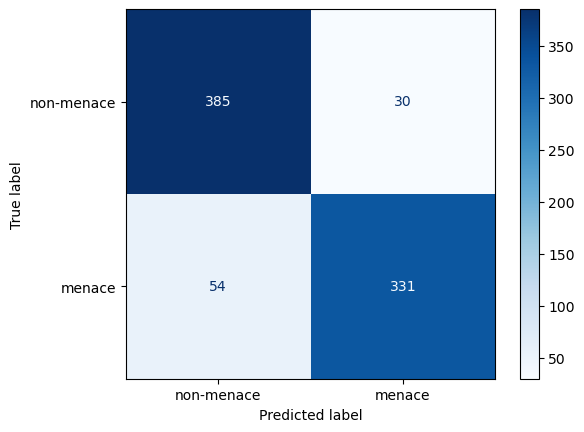

In [83]:
import time
# (c'est par l'utilisation de la fonction GridSearch que nous avons pu déterminer les meilleurs paramètres pour le random forest)
clf = RandomForestClassifier(max_depth=20, n_estimators=500, min_samples_split=15, random_state=0)

start_time = time.time()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
end_time = time.time()

# Print the best parameters and best score
print('Accuracy score with RF: ',accuracy_score(y_test, y_pred))
# print confusion matrix and plot it
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=['non-menace', 'menace'])   
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')

print(f"Time taken to run random forest classification: {end_time - start_time} seconds")

L'accuracy obtenu est de 89.5%, ce qui est bien meilleur que le résultat obtenu avec un modèle naïf (74%).

### Observations supplémentaires

In [86]:
# add cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Cross validation scores: ',scores)
print('Mean cross validation score: ',scores.mean())


Cross validation scores:  [0.8975 0.88   0.915  0.88   0.875 ]
Mean cross validation score:  0.8895


- La cross-validation semble indiquer que il n'y a pas d'overfitting et que le modèle est stable.

Feature ranking:
1. feature 0 (0.19523769262044724)
2. feature 1 (0.13574193097259213)
3. feature 7 (0.12320561381728264)
4. feature 13 (0.09856109219108436)
5. feature 2 (0.08791816520310226)
6. feature 3 (0.07862423480970082)
7. feature 14 (0.0606656222129586)
8. feature 15 (0.04797300822878627)
9. feature 12 (0.030219129660196298)
10. feature 4 (0.02623606512922893)
11. feature 9 (0.023527200310260978)
12. feature 6 (0.021631709579222832)
13. feature 10 (0.019907765803805832)
14. feature 5 (0.01767197182058375)
15. feature 8 (0.0175193592799047)
16. feature 11 (0.015359438360842517)


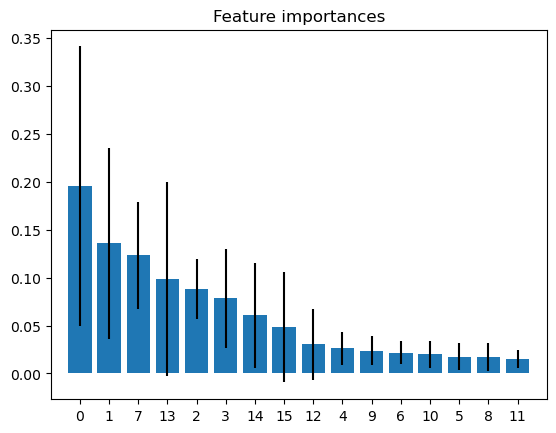

In [84]:
# Plot feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0) # compute standard deviation of feature importance
indices = np.argsort(importances)[::-1] # sort indices of feature importance
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f+1}. feature {indices[f]} ({importances[indices[f]]})")

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()



- Les caractéristiques qui semblent le plus discriminantes sont la 0, 1 et 7, cela correspond à la std de la fréquence, la moyenne de la fréquence et la moyenne de la transformée de fourier de la puissance. Cela rejoint nos observations visuelles sur les caractéristiques discriminantes, le résultat est alors cohérent.

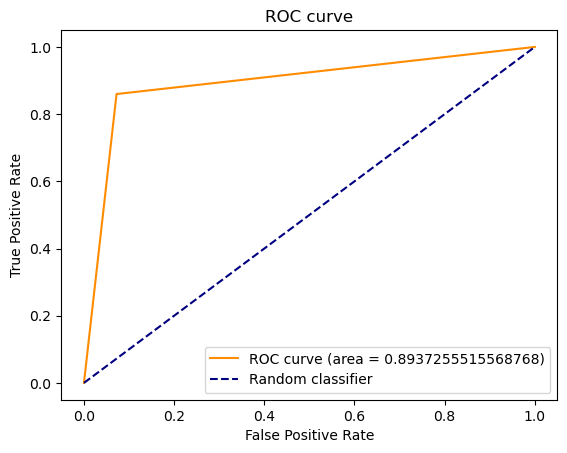

In [85]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (area = {roc_auc})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()


- La courbe ROC (Receiver Operating Characteristic) est un graphique qui permet d'évaluer la qualité d'un modèle de classification binaire. Elle représente le taux de vrais positifs (ordonnée) en fonction du taux de faux positifs (abscisse) pour différents seuils de classification. Plus la courbe se rapproche du coin supérieur gauche, plus le modèle est performant. L'aire sous la courbe (AUC) est également un indicateur de la qualité du modèle, où une AUC de 1 indique un modèle parfait et une AUC de 0,5 indique un modèle aléatoire.

- Cela nous aide à comprendre le compromis à faire entre accuracy, faux positifs, vrais positifs, aspect qui sera discuté dans la conclusion.

## Conclusion / Pour aller plus loin

L'accuracy n'est peut être pas la seule métrique intéressante pour évaluer le modèle. En effet, dans notre cas, un faux negatif (le modèle ne détecte pas une menace) a beaucoup plus d'impact opérationnel qu'un faux positif (le modèle détecte une menace qui n'en est pas une). Ici, le nombre de faux positifs(FP) (30) est deux fois plus faible que le nombre de faux negatifs(FN) (54).<br/>

Cependant, si le modèle tends à trop se focaliser sur la diminution du nombre de FN, l'accuracy va diminuer est le nombre de FP va drastiquement augmenter, il faut donc trouver le bon compromis entre accuracy et la proportion de FN. Pour cela on pourrait modifier les métriques d'évaluation.<br/>

Il serait donc intéressant d'affiner nos modèle pour trouver un trade-off entre l'accuracy, est le diminution du nombre de FN par rapport au nombre de FP. Pour cela, on pourrait créer une nouvelle métrique à minimiser et qui accorderait X fois plus d'importance aux FN qu'aux FP.

Par exemple, M = (10*FN + FP) / (FN+FP+TN+TP)

Pour l'instant vole toujours et il arrive à éviter les diverses menaces, mission accomplie ! 🛫